In [83]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [84]:
from math import sqrt, atan, degrees
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random
from google.colab import drive
from IPython.display import Image, display
import pytesseract
import shutil

In [85]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [86]:
plates_folder = '/content/gdrive/MyDrive/CARL'

In [87]:
class_names = subdirs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'ch', 'd', 'ein', 'f', 'g', 'ghaf', 'ghein', 'h2', 'hj', 'j', 'k', 'kh', 'l', 'm', 'n', 'p', 'r', 's', 'sad', 'sh', 't', 'ta', 'th', 'v', 'y', 'z', 'za', 'zad', 'zal', 'zh']
labels_nums = [i for i in range(0,len(class_names))]

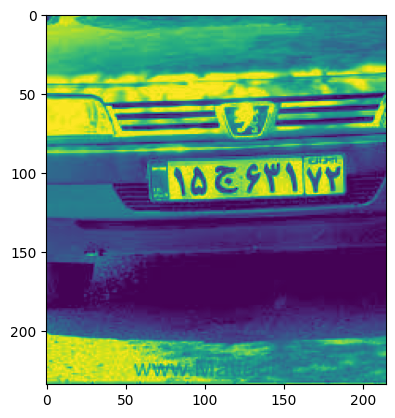

In [217]:
plate_image_gr = cv.imread(os.path.join(plates_folder, 'images (1).jpg'), 0)
plate_img = cv.imread(os.path.join(plates_folder, 'images (1).jpg'))
plt.imshow(plate_image_gr)

In [233]:
def find_longest_line(plate_img_gr):
    kernel_size = 3
    blur_gray = cv.GaussianBlur(plate_img_gr, (kernel_size, kernel_size), 0)

    low_threshold = 150
    high_threshold = 200

    edges = cv.Canny(blur_gray, low_threshold, high_threshold)

    rho = 1
    theta = np.pi / 180
    threshold = 1
    min_line_length = 50
    max_line_gap = 5
    line_image = np.copy(plate_img) * 0

    lines = cv.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    lls = []
    for indx, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
            line_length = sqrt((x2-x1)**2 + (y2-y1)**2)
            lls.append((indx,line_length))
    lls.sort(key = lambda x: x[1])
    linessorted = []
    for (indx,ll) in lls:
        linessorted.append(lines[indx])
    return linessorted

In [234]:
def find_line_angle(line):
    x1,y1,x2,y2 = line[0]
    angle = degrees(atan(((y2-y1)/(x2-x1))))
    return angle

In [235]:
def rotate_image(plate_img_gr, angle):
    (h, w) = plate_img_gr.shape
    (cX, cY) = (w // 2, h // 2)
    M = cv.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv.warpAffine(plate_img_gr, M, (w, h))
    return rotated

In [236]:
def adjust_cropping(rotated_img):
    h,w = rotated_img.shape
    targ_h = int(w/4)
    crop_h = int((h - targ_h)/2)
    cropped_rotated_img = rotated_img[crop_h:h-crop_h,:]
    return cropped_rotated_img

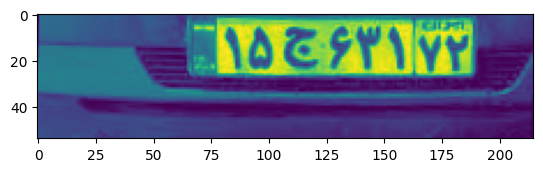

In [238]:
linessorted = find_longest_line(plate_image_gr)
rot_angle = find_line_angle(linessorted[-1])
rotated_img = rotate_image(plate_image_gr, rot_angle)
cropped_rotated_img = adjust_cropping(rotated_img)
cw = cropped_rotated_img.shape[1]

plt.imshow(cropped_rotated_img)

In [239]:
h, w = cropped_rotated_img.shape
chopfactors = [(40,120),(100,200),(180,280),(270,360),(350,400),(400,460),(460,530),(530,600)]

In [246]:
plate_letters= []
for factor in chopfactors:
    w1 = int((factor[0]/600)*w)
    w2 = int((factor[1]/600)*w)
    letterpatch = cropped_rotated_img[:,w1:w2]
    #cv.imwrite(f"{str(factor[0])}_{str(factor[1])}.png", letterpatch)
    letterpatch_resized = cv.resize(letterpatch, (28,28), interpolation= cv.INTER_LINEAR)
    plate_letters.append(letterpatch_resized)

plate_letters = np.array(plate_letters)
plate_letters.shape

(8, 28, 28)

In [247]:
ocr_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Car-L.h5')

In [248]:
predictions = ocr_model.predict(plate_letters)

1/1 [==============================] - 0s 147ms/step


In [249]:
predictions

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.1687627e-28,
        2.5088792e-11, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 3.7773863e-16, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 9.9999994e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.1148440e-11,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 9.9999994e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.1131900e-25, 0.0000000e+00, 0.0000000e+00,
        0

In [250]:
[class_names[k] for k in list(np.argmax(predictions, axis=1))]

['ta', '5', 'k', 'ta', 'hj', '5', 'hj', 'kh']